# ECE 269 - Linear Algebra - Fall 2019 - Final Project - EigenFaces

## EigenFaces project worked on by:-
## Name :- Anirudh Swaminathan
## PID :- A53316083
## Email ID :- aswamina@ucsd.edu

#### Notebook created by Anirudh Swaminathan from ECE department majoring in Intelligent Systems, Robotics and Control for the course ECE269 Linear Algebra for Fall 2019

In [1]:
%matplotlib inline

# for working with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# randomness
import random

# matrices
import numpy as np

# eigen value computation
from scipy.linalg import eigh

# for rotating images
from scipy import ndimage as ndi

In [2]:
# dataset directory specified here
data_dir = "../datasets/"

In [3]:
# data stuff here
neutral_imgs = []
smiling_imgs = []
mean_img = None
dataset = []
image_size = None
eigen_faces = None

### Load the data

In [4]:
for i in range(200):
    # Read the neutral images from the (i+1)a.jpg file
    # Read the smiling images from the (i+1)b.jpg file
    nimg = mpimg.imread(data_dir + str(i + 1) + "a.jpg")
    simg = mpimg.imread(data_dir + str(i + 1) + "b.jpg")
    neutral_imgs.append(nimg)
    smiling_imgs.append(simg)
dataset = neutral_imgs[:190]

# Convert the dataset of 190 neutral images to a numpy array
dataset = np.array(dataset)

# note down the image size
image_size = (dataset.shape[1], dataset.shape[2])
dataset = dataset.reshape(dataset.shape[0], dataset.shape[1] * dataset.shape[2])
# 31266 * 190 - dataset shape
dataset = np.transpose(dataset)

In [5]:
# convert the dataset to float to avoid errors in processing later on
dataset = dataset.astype(np.float64)

In [6]:
# convert the neutral and smiling images dataset to Numpy
neutral_imgs = np.array(neutral_imgs)
smiling_imgs = np.array(smiling_imgs)

# convert these images to float to avoid errors in processing later on
neutral_imgs = neutral_imgs.astype(np.float64)
smiling_imgs = smiling_imgs.astype(np.float64)

### Display 5 random neutral and smiling images to verify if the data loading was correct

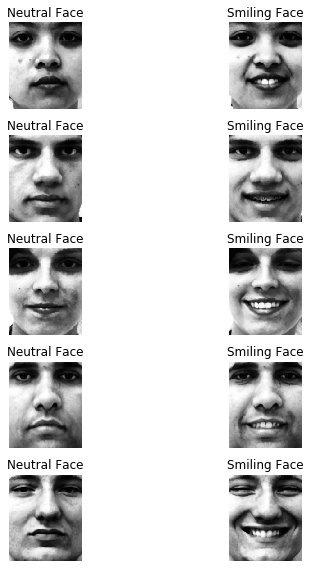

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 8), sharex="all", sharey="all")
for i in range(5):
    j = random.randint(0, 199)
    n = neutral_imgs[j]
    s = smiling_imgs[j]
    
    # display the neutral image
    axes[i][0].imshow(n, cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Neutral Face")
    
    # display the smiling image
    axes[i][1].imshow(s, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Smiling Face")
    
plt.tight_layout()
fig.canvas.draw()

### Question a) - Computing the PCs using 1st 190 individual's neutral expressions and plotting the singular values of the data matrix

#### Compute Mean Face

In [8]:
# calculate the mean face for the dataset
num_imgs = dataset.shape[1]
mean_img = np.matmul(dataset, np.ones((num_imgs, 1))) / num_imgs
# 31266 * 1 - mean_img
mean_img = mean_img
print(mean_img.shape, mean_img.dtype, np.min(mean_img), np.max(mean_img))

(31266, 1) float64 3.057894736842105 247.05789473684212


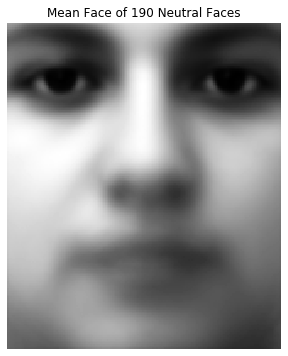

In [9]:
# plot the mean face of the neutral expressions
plt_mean_img = mean_img.reshape(image_size[0], image_size[1])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.imshow(plt_mean_img, cmap="gray")
axes.axis('off')
axes.set_title("Mean Face of 190 Neutral Faces")
fig.canvas.draw()

#### Compute the eigen values and the corresponding eigen faces

In [10]:
# 31266 * 180
mean_offset = dataset - mean_img

# 180*180
mod_cov = np.matmul(np.transpose(mean_offset), mean_offset)

# check if this is a symmetric matrix
print(np.allclose(mod_cov, np.transpose(mod_cov)))

True


In [11]:
# compute the eigen values and the corresponding eigenvectors in ascending order
# 190 eigen values
# 190 * 190 eigen vectors
# ith column - corresponding to the ith eigen vector
eig_vals, mod_eig_vecs = eigh(mod_cov)

# 31266 * 190 - eigen vectors of the original data
eig_vecs = np.matmul(mean_offset, mod_eig_vecs)

# normalize the eigen vectors now
# 31266 * 190 normalized eigen vectors
norm_cnst = np.sqrt(np.sum(np.square(eig_vecs), 0))
eigen_faces = np.divide(eig_vecs, norm_cnst)

In [12]:
# flip both eigen values and eigen vectors to ensure the largest eigen vectors are at the front
eig_vals = np.flip(eig_vals)
eigen_faces = np.flip(eigen_faces, 1)

#### Plot the singular values of the data matrix

The singular values of the data matrix $A$ are the positive square roots of the eigen values of the symmetric matrix $A^TA$. Since the matrix $A^TA$ is symmetric, it's eigen values are the squares of the singular values of $A$ and they are real.

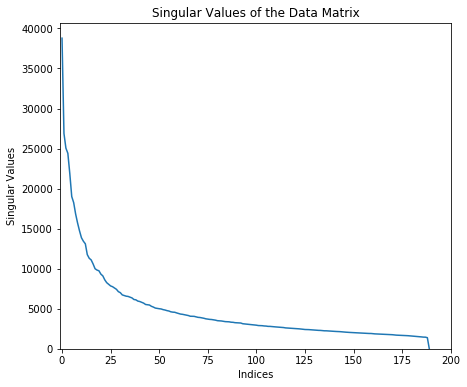

In [13]:
# plot the singular values of the data matrix
indices = [i for i in range(190)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(indices, np.sqrt(eig_vals))
axes.set_xlabel("Indices")
axes.set_ylabel("Singular Values")
axes.set_xlim(-1, 200)
axes.set_ylim(0,)
axes.set_title("Singular Values of the Data Matrix")
fig.canvas.draw()

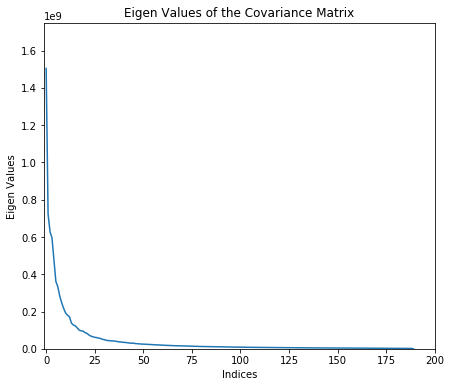

In [14]:
# plot the eigen values of the covariance matrix
indices = [i for i in range(190)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(indices, eig_vals)
axes.set_xlabel("Indices")
axes.set_ylabel("Eigen Values")
axes.set_xlim(-1, 200)
axes.set_ylim(0, 1.75e9)
axes.set_title("Eigen Values of the Covariance Matrix")
fig.canvas.draw()

$$\textbf{Choosing number of eigen vectors to form PCs}$$
As given in the discussion, we can fix our metric for choosing the number of eigen vectors to form the Principal Components. In my case, I am choosing to compute the number of eigen values whose sum is greater than 95% of the sum of all the eigen values. <br>
As given in the paper "Face Recognition Using Eigenfaces" in Section $2$, it states that "The faces can be approximated using only the best eigenfaces - those that have the largest eigenvalues, and which therefore account for the most variance within the set of face images". <br>
For choosing the eigen vectors, we take the largest eigen values as they indicate the maximum variance between the different features.

In [15]:
tot = np.sum(eig_vals)
su = 0
ans = -1
for j in range(190):
    su += eig_vals[j]
    if su/tot>0.95:
        ans = j+1
        print("The largest {} eigen vectors encode >95% variability of the dataset".format(ans))
        break

The largest 96 eigen vectors encode >95% variability of the dataset


In [16]:
# I can call this the critical number of eigen vectors
critic_eig = ans

Hence, we can choose $96$ largest eigen values and their corresponding eigen vectors to represent greater than $95%$ variability of the given dataset of faces.

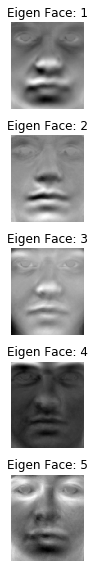

In [17]:
# plot the top 5 eigen faces
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 8), sharex="all", sharey="all")
for i in range(5):
    img = eigen_faces[:, i]
    plot_face = img.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i].imshow(plot_face, cmap="gray")
    axes[i].axis('off')
    axes[i].set_title("Eigen Face: {}".format(i+1))
    
plt.tight_layout()
fig.canvas.draw()

### Question b) - Reconstruction of a neutral individual's face using different number of PC's

In [18]:
def reconstruct_image(orig, pcs):
    """
    A function to reconstruct the original image with the given PCs
    Arguments
    orig - Original image to perform reconstruction on
    pcs  - The principal components to use for the reconstruction
    
    Returns
    recon - The reconstruction of the orig from pcs
    mse   - The Mean Squared Error of the recon with orig
    """
    # perform mean subtraction
    # 31566 * 1
    mean_sub = orig - mean_img
    
    # calculate the weights
    # l * 31566 * 31566 * 1 = l * 1
    w = np.matmul(np.transpose(pcs), mean_sub)
    
    # 31566 * l * l * 1 = 31566 * 1
    recon = np.matmul(pcs, w) + mean_img
    mse = np.mean(np.square(orig - recon))
    return recon, mse

In [19]:
# random index to pick image from
rand_ind = random.randint(0, 189)
original_img = dataset[:, rand_ind]
original_img = original_img[:, np.newaxis]

In [20]:
mses = []
recs = []

# Reconstruct the image for all the PCs
for j in range(190):
    pcs = eigen_faces[:, :(j+1)]
    rec, mse = reconstruct_image(original_img, pcs)
    recs.append(rec)
    mses.append(mse)

In [21]:
print(len(mses), min(mses), max(mses))

190 1.9767356827341849e-25 912.1126165027619


In [25]:
print(mses, mses[95])

[912.1126165027619, 846.247836859863, 620.5029760053293, 607.7582094663536, 607.7497183362971, 591.2634170466384, 589.1354069709935, 585.6884167020107, 567.1328163670867, 543.9780561004981, 541.1325152092243, 530.3225252062759, 527.1242225676779, 524.5407649065439, 523.815379716753, 518.1845638244178, 509.6281642976817, 495.1910124166925, 494.6726767325833, 467.8328912119583, 462.96040881502387, 453.124389714335, 369.24704430332537, 369.09623413715434, 368.5880939146202, 368.49352393216054, 361.5742248141947, 357.3236983388494, 353.7029266485275, 352.16683217738955, 315.4895619407959, 311.1928878882515, 307.1208072348853, 306.6927930829985, 297.1653491756406, 296.45037536384325, 295.5233778512395, 293.6775923197246, 293.6122117825074, 264.86495712527807, 254.46983870191679, 251.07236282691187, 247.39216990207834, 246.02502036431065, 231.75263027845847, 227.93550782761832, 227.22231276431754, 225.34627221566004, 221.5570495519389, 221.55191268387387, 219.9451619464829, 217.5003816239371

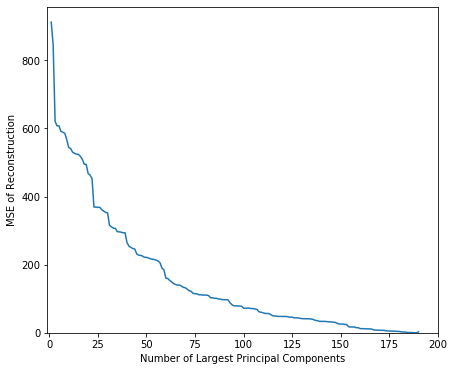

In [23]:
# plot the MSE of reconstruction vs number of largest principal components used
num_eigs = [i+1 for i in range(190)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(num_eigs, mses)
axes.set_xlabel("Number of Largest Principal Components")
axes.set_ylabel("MSE of Reconstruction")
axes.set_xlim(-1, 200)
axes.set_ylim(0, )
#axes.set_title("Number of Principal Components vs Mean Squared Error of Reconstruction")
fig.canvas.draw()

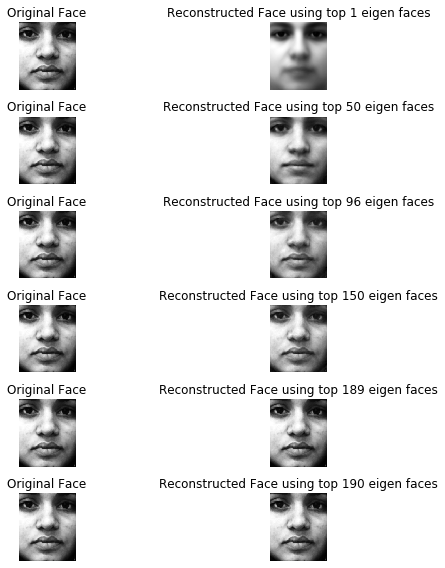

In [24]:
# Plot the reconstructed images for 5 different number of PCs
num_pcs = [1, 50, critic_eig, 150, 189, 190]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 8), sharex="all", sharey="all")
for i in range(len(num_pcs)):
    r = recs[num_pcs[i] - 1]
    r = r.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Face")
    
    # display the smiling image
    axes[i][1].imshow(r, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Reconstructed Face using top {} eigen faces".format(num_pcs[i]))
    
plt.tight_layout()
fig.canvas.draw()

$$\textbf{Qualitative Results}$$
I reconstructed a random neutral image from the $1^{st}$ $190$ neutral images using different number of principal components associated with the largest eigen values. <br>
I found that the reconstructed image was not visually close for just $1$ principal component. <br>
As the number of principal components increases, I found that the reconstructed image starts resembling the original image. The best results seem to be obtained after $96$ PCs, which is the critical number of PCs that I calculated. <br>
$$\textbf{Quantitave Results}$$
As the number of principal components associated with the largest eigen values used to recreate the neutral image increases, the MSE for my model keeps on decreasing to $0$. This is to be expected as this random neutral image that we picked was used in the computation of all the $190$ eigen faces, and hence, this neutral image can be spanned by all the $190$ principal components. <br>
For $96$ PCs, the MSE was $79.275$, which is a good reconstruction MSE for just half the total number of principal components. This means that on average, the pixel values between reconstructed image and the original image differ by just a value of $9$, which should be imperceptible to the human eye. <br>
Also, as a sanity check, the highest MSE that we obtained was lesser than $255^2$, which is the largest possible error that can be obtained between $2$ grayscale images. The highest MSE was $912$ for just $1$ component, and it lowered to $1.977\times10^{-25}$

### Question c) - Reconstruction of a smiling individual's PCs using different number of PC's

In [26]:
# pick the same index, but from the smiling part instead
original_img = smiling_imgs[rand_ind, :, :]
original_img = original_img.reshape(image_size[0] * image_size[1], 1)

In [27]:
sm_mses = []
sm_recs = []

# Reconstruct the image for all the PCs
for j in range(190):
    pcs = eigen_faces[:, :(j+1)]
    rec, mse = reconstruct_image(original_img, pcs)
    sm_recs.append(rec)
    sm_mses.append(mse)

In [28]:
print(len(sm_mses), min(sm_mses), max(sm_mses))

190 652.5715172733268 2896.4428306766417


In [29]:
print(sm_mses, sm_mses[95])

[2896.4428306766417, 2886.1482624691193, 2539.5251776291652, 2507.4446929647984, 2506.575407923283, 2329.806047227617, 1901.9994885116412, 1889.634918228657, 1858.2370960979736, 1857.492637183126, 1847.4613832523046, 1838.6830791530356, 1800.6842304625527, 1669.6998811449334, 1664.9138838224383, 1661.5096346154994, 1652.0713256326937, 1641.46271889424, 1613.7028990935569, 1414.7818937002414, 1404.4686864820185, 1399.7477150581487, 1395.3120440236983, 1393.4741289334956, 1389.3274030339028, 1372.5184527564536, 1336.9864076828696, 1316.0310085247913, 1315.6243535878793, 1256.0960758153003, 1255.5944022495123, 1192.839650331781, 1172.5137794020914, 1169.0576190591626, 1167.069435886754, 1164.4277126507914, 1149.760541474684, 1148.2975007749383, 1129.802531776162, 1125.6369651426587, 1122.9935979431864, 1090.8855839963787, 1079.0257835105756, 1057.1774297514887, 1055.021048675191, 1054.7130621566173, 1044.111812698975, 1044.0836047580965, 1038.7665414433538, 1038.7573567030622, 1038.218017

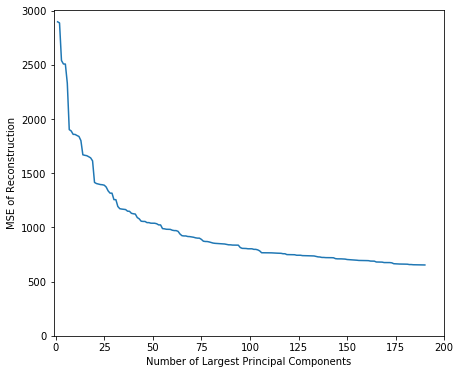

In [30]:
# plot the MSE of Reconstruction vs the Number of Largest Principal Components
num_eigs = [i+1 for i in range(190)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(num_eigs, sm_mses)
axes.set_xlabel("Number of Largest Principal Components")
axes.set_ylabel("MSE of Reconstruction")
axes.set_xlim(-1, 200)
axes.set_ylim(0, )
#axes.set_title("Number of Principal Components vs Mean Squared Error of Reconstruction")
fig.canvas.draw()

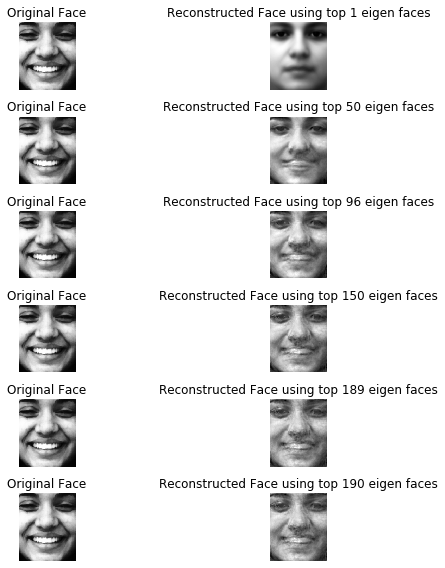

In [32]:
# Plot the reconstructed images for 5 different number of PCs
num_pcs = [1, 50, critic_eig, 150, 189, 190]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 8), sharex="all", sharey="all")
for i in range(len(num_pcs)):
    r = sm_recs[num_pcs[i] - 1]
    r = r.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Face")
    
    # display the smiling image
    axes[i][1].imshow(r, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Reconstructed Face using top {} eigen faces".format(num_pcs[i]))
    
plt.tight_layout()
fig.canvas.draw()

$$\textbf{Qualitative Results}$$
I reconstructed a random smiling image from the $1^{st}$ $190$ smiling images using different number of principal components associated with the largest eigen values. <br>
I used the same face for both neutral and for smiling images in this project for ease of comparison. <br>
Visually, the reconstructed images get better as the number of eigen faces that we use increases. But, this is still not as good as the reconstruction that we perform for the neutral images. <br>
This is because in this specific example, we find that the smiling image shows teeth, which is not present in any of the neutral images. Also, for this specific example for the smiling image, the eyes of the face are also closed, which is different compared to the neutral faces where the eyes are in the normal open position. The mean image also reflects that fact that the eyes are open normally for the neutral images. <br>
Hence, we find that the results are qualitatively not as great as we obtained for the reconstruction of neutral images.
$$\textbf{Quantitave Results}$$
As the number of principal components associated with the largest eigen values used to recreate the smiling image increases, the MSE for my model keeps on decreasing. But, the MSE of reconstruction does $\textbf{not}$ approach $0$. <br>
The reason for this is that the smiling images are not a part of the process of finding the principal components. Hence, with the given principal components, we cannot span the set of smiling images effectively. <br>
For $96$ PCs, the MSE was $806.682$. Here, we find that $96$ PCs do not adequately capture the smiling images, but then, increasing the number of principal components used slightly decreases the MSE. <br>
Also, as a sanity check, the highest MSE that we obtained was lesser than $255^2$, which is the largest possible error that can be obtained between $2$ grayscale images. The highest MSE was $2896.4$ for just $1$ component, and it lowered to $652.572$
$$\textbf{Comparison with Neutral Image Reconstruction}$$
This reconstruction is not as good as the neutral image reconstruction. This is because the smiling image was not a part of process of finding the principal components. Hence, with the given principal components, we cannot span the space of smiling images. We can only approximate the smiling image through this process.

### Question d) Reconstruction of test set of neutral images from the Principal Components

In [ ]:
# random index to pick image from
rand_neut = random.randint(190, 199)
original_img = neutral_imgs[rand_neut, :, :]
print(original_img.shape)
original_img = original_img.reshape(image_size[0] * image_size[1], 1)
print(original_img.shape, original_img.dtype, np.min(original_img), np.max(original_img))

In [ ]:
te_mses = []
te_recs = []

# Reconstruct the image for all the PCs
for j in range(190):
    #print(dataset.shape)
    pcs = eigen_faces[:, :(j+1)]
    #print(pcs.shape)
    rec, mse = reconstruct_image(original_img, pcs)
    te_recs.append(rec)
    te_mses.append(mse)

In [ ]:
print(len(te_mses), min(te_mses), max(te_mses))

In [ ]:
print(te_mses)

In [ ]:
# plot the singular values of the data matrix
num_eigs = [i+1 for i in range(190)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(num_eigs, te_mses)
axes.set_xlabel("Number of Largest Principal Components")
axes.set_ylabel("MSE of Reconstruction")
axes.set_xlim(-1, 200)
axes.set_ylim(0,)
#axes.set_title("Number of Principal Components vs Mean Squared Error of Reconstruction")
fig.canvas.draw()

In [ ]:
# Plot the reconstructed images for 5 different number of PCs
num_pcs = [1, 50, 100, 150, 189, 190]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 8), sharex="all", sharey="all")
for i in range(len(num_pcs)):
    r = te_recs[num_pcs[i] - 1]
    print(r.shape, r.dtype)
    r = r.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Face")
    
    # display the smiling image
    axes[i][1].imshow(r, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Reconstructed Face using top {} eigen faces".format(num_pcs[i]))
    
plt.tight_layout()
fig.canvas.draw()

In [ ]:
r = sm_recs[188]
print(r.shape, r.dtype, np.min(r), np.max(r))
print(original_img.shape, original_img.dtype, np.min(original_img), np.max(original_img))

$$\textbf{Qualitative Results}$$
I tried reconstruction of a random neutral image using different number of principal components with the largest eigen values <br>
I found that the reconstructed image was not close for just $1$ principal component. <br>
For more principal components, I found that the reconstructed image starts resembling the original image. <br>
$$\textbf{Quantitave Results}$$
As the number of principal components associated with the largest eigen values used to recreate the neutral image increases, the MSE for my model keeps on decreasing. This is to be expected, as the number of Pricipal components increases, they are able to approximately span the original image more and more. <br>
$$\textbf{Comparison with Neutral Image Reconstruction}$$
This reconstruction is not as good as the neutral images reconstruction. This is because this neutral image was not a part of process of finding the principal components. Hence, with the given principal components, we cannot span this image.
$$\textbf{Comparison with Smiling Image Reconstruction}$$
This reconstruction is very similar to the one performed on smiling images, and the same argument applies. The fact that they do not contribute to finding the Principal Components leads to the fact that they cannot efficiently reconstruct the given image.

### Question e) Reconstruction of non-human image from the set of PCs

In [ ]:
# read car
car_pth = "../datasets/car.jpg"
car_img = mpimg.imread(car_pth)
car_img = car_img.astype(np.float64)
original_img = car_img.reshape(image_size[0] * image_size[1], 1)
print(original_img.shape, original_img.dtype, np.min(original_img), np.max(original_img))

In [ ]:
# Reconstruct the image for all the PCs
#print(dataset.shape)
pcs = eigen_faces
print(eigen_faces.shape)
#print(pcs.shape)
rec, mse = reconstruct_image(original_img, pcs)

In [ ]:
print(mse)

In [ ]:
# reconstruct for 189 PCs
pcs = eigen_faces[:, :189]
print(pcs.shape)
rec2, mse2 = reconstruct_image(original_img, pcs)

In [ ]:
print(mse2)

In [ ]:
# reconstruct for all 190 pcs
pcs = eigen_faces[:, :190]
print(pcs.shape)
rec3, mse3 = reconstruct_image(original_img, pcs)

In [ ]:
print(mse3)

In [ ]:
recs = [rec2, rec]

In [ ]:
# Plot the reconstructed images for 5 different number of PCs
num_pcs = [189, 190]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex="all", sharey="all")
for i in range(len(num_pcs)):
    r = recs[i]
    print(r.shape, r.dtype)
    r = r.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Image")
    
    # display the smiling image
    axes[i][1].imshow(r, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Reconstructed Image using top {} eigen faces".format(num_pcs[i]))
    
plt.tight_layout()
fig.canvas.draw()

In [ ]:
r = rec2
print(r.shape, r.dtype, np.min(r), np.max(r))
print(original_img.shape, original_img.dtype, np.min(original_img), np.max(original_img))

TODO

### Question f) Reconstruction of training set neutral image for different rotations

In [ ]:
original_img = dataset[:, rand_ind]
original_img = np.reshape(original_img, (image_size[0], image_size[1]))

In [ ]:
mses = []
rots = []
recs = []

pcs = eigen_faces[:, :189]

# Reconstruct the image for all the PCs
for j in range(361):
    #print(dataset.shape)
    rot_image = ndi.rotate(original_img, j, reshape=False)
    rot_image = rot_image.reshape(image_size[0]*image_size[1], 1)
    rots.append(rot_image)
    #print(rot_image.shape, rot_image.dtype)
    #print(pcs.shape)
    rec, mse = reconstruct_image(rot_image, pcs)
    recs.append(rec)
    mses.append(mse)

In [ ]:
print(len(mses), min(mses), max(mses))

In [ ]:
print(mses)

In [ ]:
# plot the singular values of the data matrix
angles = [i for i in range(361)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(angles, mses)
axes.set_xlabel("Angle of rotation in degrees")
axes.set_ylabel("MSE of Reconstruction")
axes.set_xlim(-1, 400)
axes.set_ylim(0, )
#axes.set_title("Number of Principal Components vs Mean Squared Error of Reconstruction")
fig.canvas.draw()

In [ ]:
# Plot the reconstructed images for 5 different number of PCs
angles = [0, 30, 60, 90, 120, 180, 240, 270, 300, 360]
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 12), sharex="all", sharey="all")
for i in range(len(angles)):
    r = recs[angles[i]]
    print(r.shape, r.dtype)
    r = r.reshape(image_size[0], image_size[1])
    
    ro = rots[angles[i]]
    print(ro.shape, ro.dtype)
    ro = ro.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Face")
    
    # display the rotated image
    axes[i][1].imshow(ro, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Rotated Image Angle: {}".format(angles[i]))
    
    # display the smiling image
    axes[i][2].imshow(r, cmap="gray")
    axes[i][2].axis('off')
    axes[i][2].set_title("Reconstructed Face with 189 PCs".format(angles[i]))
    
plt.tight_layout()
fig.canvas.draw()

In [ ]:
mses = []
rots = []
recs = []

pcs = eigen_faces[:, :190]

# Reconstruct the image for all the PCs
for j in range(361):
    #print(dataset.shape)
    rot_image = ndi.rotate(original_img, j, reshape=False)
    rot_image = rot_image.reshape(image_size[0]*image_size[1], 1)
    rots.append(rot_image)
    #print(rot_image.shape, rot_image.dtype)
    #print(pcs.shape)
    rec, mse = reconstruct_image(rot_image, pcs)
    recs.append(rec)
    mses.append(mse)

In [ ]:
print(len(mses), min(mses), max(mses))

In [ ]:
print(mses)

In [ ]:
# plot the singular values of the data matrix
angles = [i for i in range(361)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
axes.plot(angles, mses)
axes.set_xlabel("Angle of rotation in degrees")
axes.set_ylabel("MSE of Reconstruction")
axes.set_xlim(-5, 400)
axes.set_ylim(0, )
#axes.set_title("Number of Principal Components vs Mean Squared Error of Reconstruction")
fig.canvas.draw()

In [ ]:
# Plot the reconstructed images for 5 different number of PCs
angles = [0, 30, 60, 90, 120, 180, 240, 270, 300, 360]
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 12), sharex="all", sharey="all")
for i in range(len(angles)):
    r = recs[angles[i]]
    print(r.shape, r.dtype)
    r = r.reshape(image_size[0], image_size[1])
    
    ro = rots[angles[i]]
    print(ro.shape, ro.dtype)
    ro = ro.reshape(image_size[0], image_size[1])
    
    # display the neutral image
    axes[i][0].imshow(original_img.reshape(image_size[0], image_size[1]), cmap="gray")
    axes[i][0].axis('off')
    axes[i][0].set_title("Original Face")
    
    # display the rotated image
    axes[i][1].imshow(ro, cmap="gray")
    axes[i][1].axis('off')
    axes[i][1].set_title("Rotated Image Angle: {}".format(angles[i]))
    
    # display the smiling image
    axes[i][2].imshow(r, cmap="gray")
    axes[i][2].axis('off')
    axes[i][2].set_title("Reconstructed Face with all PCs".format(angles[i]))
    
plt.tight_layout()
fig.canvas.draw()

TODO

TODO - Final answers to stuff, conclusions, math